In [13]:
from trikde.pdfs import DensitySamples, IndepdendentLikelihoods, MultivariateNormalPriorHyperCube, CustomPriorHyperCube
import os
from lenslikelihood.measurements import flux_measurements, flux_measurement_uncertainties, all_lens_names, all_param_ranges
import pickle

import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt


## Folding new priors into the inference

This notebook demonstrates how to fold in new priors on various hyper-parameters. We'll consider two different priors:

1) a prior on the normalization and slope of the subhalo mass function inferred from stellar streams

2) a prior on the concentration-mass relation based on observations of dwarf galaxies 

First, we will load the pre-computed lensing-only likelihoods. These can be computed and saved for later use with the notebook "inference_5D_from_scatch". 

In [14]:
nbins = 20
likelihoods, likelihoods_coupled = [], []
param_names = ['LOS_normalization', 'beta', 'c0', 'delta_power_law_index', 'sigma_sub']
param_ranges = [all_param_ranges[name] for name in param_names]
load_from_pickle = True 
save_to_pickle = False 
filename_extension = '_joint'
filename_extension_coupled = '_joint_coupled'
base_path = './../lenslikelihood/precomputed_likelihoods/'

for lens in all_lens_names:
    
    fname = base_path + lens + filename_extension
    print('loading joint likelihoods for lens '+lens+' ...')
    f = open(fname, 'rb')
    single_lens_likelihood = pickle.load(f)
    f.close()
    likelihoods.append(single_lens_likelihood)
    
    fname = base_path + lens + filename_extension_coupled
    f = open(fname, 'rb')
    single_lens_likelihood = pickle.load(f)
    f.close()
    likelihoods_coupled.append(single_lens_likelihood)
    
likelihood = IndepdendentLikelihoods(likelihoods)
likelihood_coupled = IndepdendentLikelihoods(likelihoods_coupled)

loading joint likelihoods for lens B1422 ...
loading joint likelihoods for lens HE0435 ...
loading joint likelihoods for lens WGD2038 ...
loading joint likelihoods for lens WGDJ0405 ...
loading joint likelihoods for lens WFI2033 ...
loading joint likelihoods for lens PSJ1606 ...
loading joint likelihoods for lens WFI2026 ...
loading joint likelihoods for lens RXJ0911 ...
loading joint likelihoods for lens RXJ1131 ...
loading joint likelihoods for lens MG0414 ...
loading joint likelihoods for lens PG1115 ...


### Prior on the amplitude and slope of the subhalo mass function inferred from stellar streams https://arxiv.org/pdf/1911.02662.pdf

Banik et al. (2021) used a paramterization for the subhalo mass function

\begin{equation}
\frac{dn}{dm} = a \left(\frac{m}{m_0}\right)^{\alpha} \exp{ \Big\{ -\frac{2}{\alpha_r}\left[\left(\frac{r}{r_{-2}}\right)^{\alpha_r} - 1\right] \Big\} }
\end{equation}

with $m_0 = 2.52 \times 10^7 M_{\odot}$, $\alpha_r = 0.672$, $r_{-2} = 162.4 \rm{kpc}$, and normalization $a = 2.02\times 10^{-13} M_{\odot}^{-1} \rm{kpc^{-3}}$. To map into lensing units $\Sigma_{\rm{sub}}$, we have to project this into two dimensions. 



projected mass at r=0 [M/kpc^2]:  2327310.34705692
projected mass using lensing parameterization with sigma_sub = 0.0244 [M/kpc^2]:  23276034.690734457


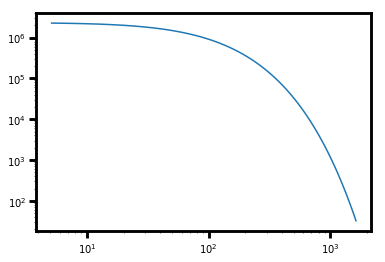

In [15]:
def projected_mass_function(r2d, a=2.02e-13, alpha=-1.9, m0=2.52e+7, r_minus2=162.4, 
                            alpha_r=0.672, mlow=10**6, mhigh=10**10):
    
    def _spatial_integrand(z):
        r = np.sqrt(r2d**2 + z**2)
        x = r/r_minus2
        return np.exp(-(2/alpha_r) * ((x)**alpha_r - 1))
    
    mass_function_1st_moment = a/(2 + alpha)/m0**alpha * ( mhigh**(2+alpha) - mlow ** (2+alpha))
    spatial_integral = 2 * quad(_spatial_integrand, 0, 100 * r_minus2)[0]
    
    # returns the projected mass in substructure [M_sun / kpc^2] using the parameterization in Banik et al. 2021
    return spatial_integral * mass_function_1st_moment

def projected_mass_lensing(sigma_sub, m_host, z, mlow=10**6, mhigh=10**10, alpha=-1.9, m0=10**8):
    
    host_redshift_scaling = 0.88 * np.log10(m_host/10**13) + 1.7 * np.log10(1+z)
    
    # returns the projected mass in substructure as parameterized in the lensing analysis
    return sigma_sub/(2 + alpha)/m0**(1+alpha) * ( mhigh**(2+alpha) - mlow ** (2+alpha))

r_minus2 = 162.4
r = np.logspace(-1.5, 1, 100) * r_minus2
projected_mass_density = [projected_mass_function(ri) for ri in r]
plt.loglog(r, projected_mass_density)

# since the projected density is almost constant in lenses around the Einstein radius, we will compare to the projected
# mass at r = 0. 
print('projected mass at r=0 [M/kpc^2]: ', projected_mass_function(0.))
print('projected mass using lensing parameterization with sigma_sub = 0.0244 [M/kpc^2]: ', 
      projected_mass_lensing(0.0244, 1.4 * 10**12, 0.))

Using the functions in the cell above, we can propagate the value of sigma_sub inferred from lensing to Milky Way like halos and vice versa. As shown in the cell above, the stellar streams inference on the subhalo mass function cast in terms of the lensing parameterization corresponds to $\Sigma_{\rm{sub}} = 0.0244$, assuming that tidal stripping is equally efficient in the Milky Way compared to massive ellipticls. 

If disruption is equally efficient in the Milky Way as in lens halos, then the matching value of sigma_sub would be 0.0244. If twice as many subhalos are disrupted in the MW relative to lens halos, then the matching value would be 0.0488. To see how this information affects the lensing results, we can add a prior on the subhalo mass function inferred from the lenses. 

We will also add a prior on the line of sight halo mass function of $\delta_{\rm{LOS}} = 1 \pm 0.2$, corresponding to the Sheth-Tormen halo mass function prediction with an uncertainty of $20\%$. 

In [16]:
# Recall the parameter ordering: 
# param_names = ['sigma_sub', 'LOS_normalization', 'beta', 'c0', 'delta_power_law_index']

# assumes subhalos are disrupted at the same rate in the Milky Way as in ellipticals
means = [None, None, None, None, 0.025]
sigmas = [None, None, None, None, means[-1] * 0.2]

prior_on_sigma_sub = MultivariateNormalPriorHyperCube(means, sigmas, param_names, param_ranges, nbins)
likelihoods_coupled_with_prior = likelihoods_coupled + [prior_on_sigma_sub]
likelihood_coupled_with_prior = IndepdendentLikelihoods(likelihoods_coupled_with_prior)

# assumes subhalos are disrupted twice as much in the MW as in ellipticals
means = [None, None, None, None, 0.05]
sigmas = [None, None, None, None, means[-1] * 0.2]
prior_on_sigma_sub_2 = MultivariateNormalPriorHyperCube(means, sigmas, param_names, param_ranges, nbins)
likelihoods_coupled_with_prior_2 = likelihoods_coupled + [prior_on_sigma_sub_2]
likelihood_coupled_with_prior_2 = IndepdendentLikelihoods(likelihoods_coupled_with_prior_2)

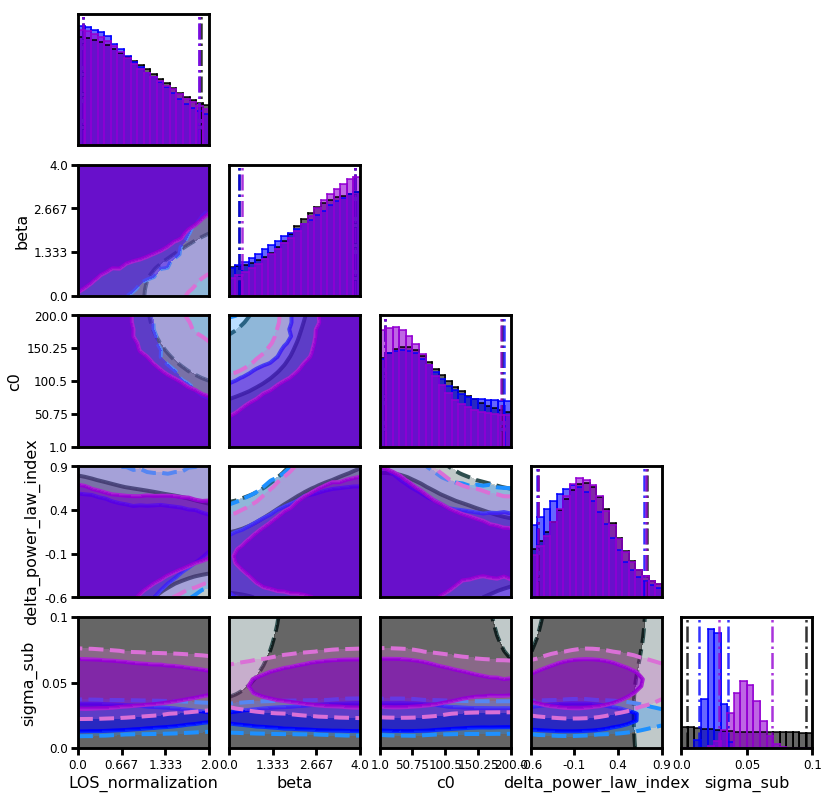

In [17]:
from trikde.triangleplot import TrianglePlot

triangle_plot = TrianglePlot([likelihood, likelihood_coupled_with_prior, likelihood_coupled_with_prior_2])
axes = triangle_plot.make_triplot(filled_contours=True, show_intervals=True, show_contours=True)

### Custom priors

To add more complicated priors, we can use a CustomPriorHyperCube object. This class takes as input a function that computes a chi2 for each sample, given the full array of samples in the likelihood. As an example, we'll use this to enforce a prior on the normalization and slope of the concentration-mass relation such that a 10^10 solar mass halo as a concentration of 12.5 plus/minus 4 at z=0. 

Note: this cell requires the software package colossus http://www.benediktdiemer.com/code/colossus/

In [18]:
from colossus.halo.concentration import peaks
from colossus.cosmology import cosmology
from trikde.pdfs import CustomPriorHyperCube

kwargs_cosmo = {'H0': 69.7, 'Om0': 0.0464 + 0.235, 'Ob0': 0.0464, 'ns': 0.9608, 'sigma8': 0.82}
cosmology.setCosmology('custom', kwargs_cosmo)
# from pyHalo.Halos.lens_cosmo import LensCosmo
# lc = LensCosmo()
# c = [lc.NFW_concentration(10**10, 0., scatter=True) for i in range(0, 1000)]
# print(np.mean(c), np.std(c))
def anchor_mc_relation_function(samples, log10_m_anchor=10, c_at_anchor=12.5, sigma=4, little_h=0.697):
    
    c8_samples = samples[:, 2]
    beta_samples = samples[:, 1]
    m_ref = 10 ** 8 * little_h
    m = 10 ** log10_m_anchor * little_h
    nu = peaks.peakHeight(m, z=0)
    nu_ref = peaks.peakHeight(m_ref, z=0)
    nu_ratio = nu/nu_ref
    c_model = c8_samples * nu_ratio ** -beta_samples
    chi2 = (c_at_anchor - c_model)**2/sigma**2 
    return chi2

prior_on_mc_relation = CustomPriorHyperCube(anchor_mc_relation_function, param_names, param_ranges, nbins)
likelihoods_coupled_with_prior_on_MC = likelihoods_coupled + [prior_on_mc_relation] + [prior_on_sigma_sub_2]
likelihood_coupled_with_prior_on_MC = IndepdendentLikelihoods(likelihoods_coupled_with_prior_on_MC)

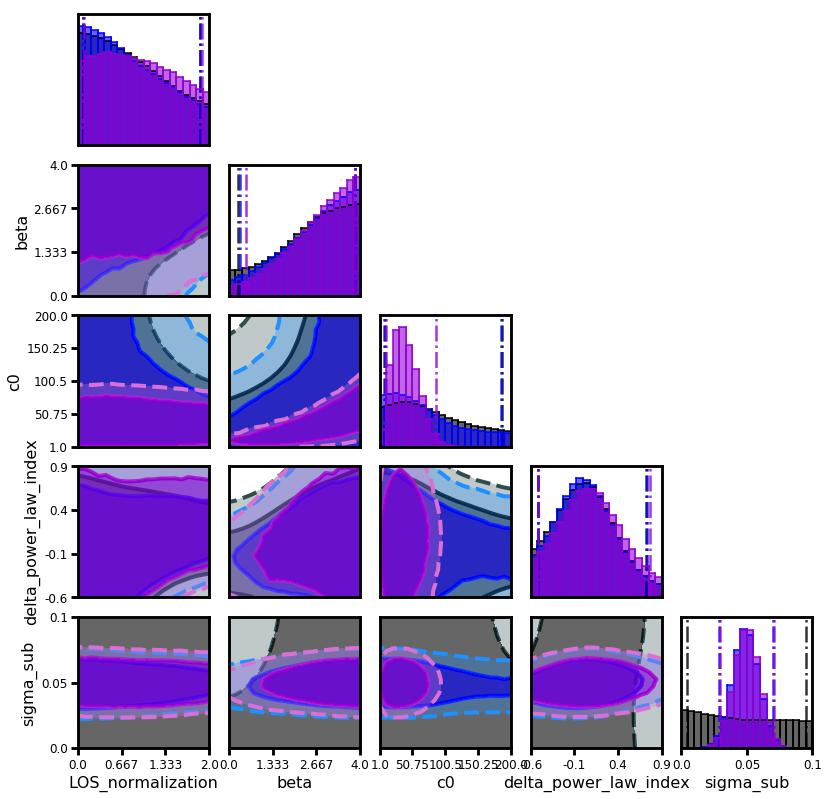

In [19]:
from trikde.triangleplot import TrianglePlot

triangle_plot = TrianglePlot([likelihood, likelihood_coupled_with_prior_2, likelihood_coupled_with_prior_on_MC])
axes = triangle_plot.make_triplot(filled_contours=True, show_intervals=True, show_contours=True)

Finally, we can experiment with priors on $\beta$, $\Sigma_{\rm{sub}}$, and $\delta_{\rm{LOS}}$.

In [20]:
means = [1., 0.83, 18, None, 2 * 0.0244]
sigmas = [0.2, 0.2, 5., None, 0.005]
prior_on_beta_sigmasub_deltalos = MultivariateNormalPriorHyperCube(means, sigmas, param_names, param_ranges, nbins)
likelihoods_coupled_with_prior_on_beta_and_sigma_sub = likelihoods_coupled + [prior_on_beta_sigmasub_deltalos]
likelihood_coupled_with_prior_on_beta_and_sigma_sub = IndepdendentLikelihoods(likelihoods_coupled_with_prior_on_beta_and_sigma_sub)

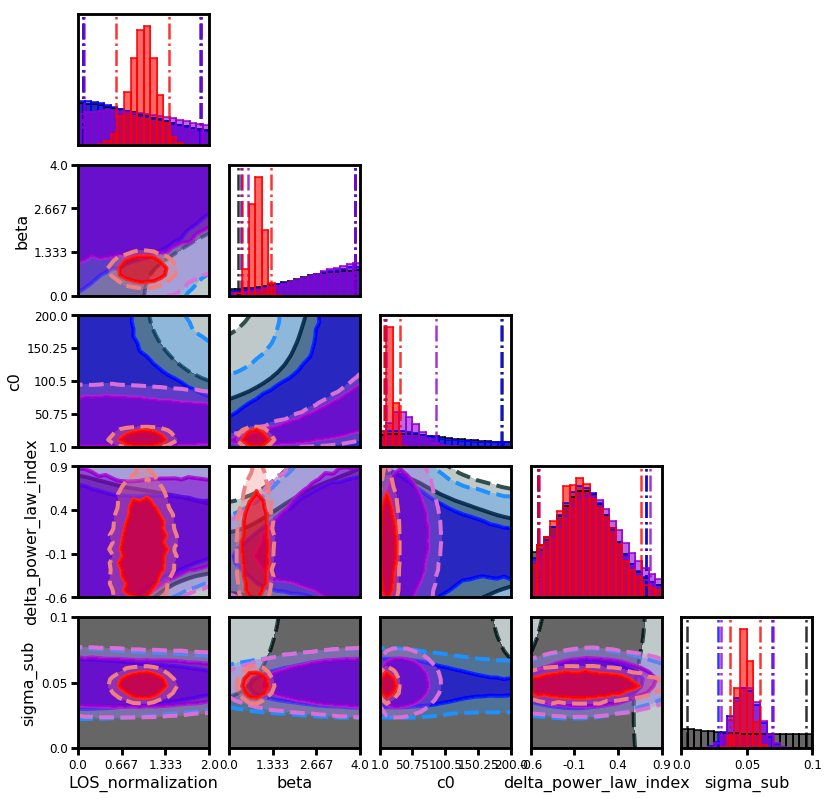

In [21]:
triangle_plot = TrianglePlot([likelihood, likelihood_coupled_with_prior_2, likelihood_coupled_with_prior_on_MC,
                             likelihood_coupled_with_prior_on_beta_and_sigma_sub])
axes = triangle_plot.make_triplot(filled_contours=True, show_intervals=True, show_contours=True)

In [22]:
help(triangle_plot.get_parameter_confidence_interval)
print('bin_width: ', (0.9 + 0.6)/20)
triangle_plot.get_parameter_confidence_interval('delta_power_law_index', 0., chain_num=None, thresh=0.68)

Help on method get_parameter_confidence_interval in module trikde.triangleplot:

get_parameter_confidence_interval(parameter, clevel, chain_num=None, show_percentage=False, return_intervals=False, print_intervals=True, thresh=None) method of trikde.triangleplot.TrianglePlot instance

bin_width:  0.075
parameter name:  delta_power_law_index
68.0% confidence intervals: 
format: median (lower, upper)

SAMPLES 1:
0.024081322738921607 (-0.3153911556133603, 0.3704173319784855)
width:  0.6858084875918458
SAMPLES 2:
0.020086587180486504 (-0.29267100325453127, 0.37902585312776693)
width:  0.6716968563822983
SAMPLES 3:
0.0831535008927971 (-0.26645877355975695, 0.4622652109226838)
width:  0.7287239844824407
SAMPLES 4:
-0.007989553054820464 (-0.3106306511346696, 0.3298346784260081)
width:  0.6404653295606777


In [23]:
help(triangle_plot.get_parameter_confidence_interval)
print('bin_width: ', (0.9 + 0.6)/20)
triangle_plot.get_parameter_confidence_interval('delta_power_law_index', 0., chain_num=None, thresh=0.95)

Help on method get_parameter_confidence_interval in module trikde.triangleplot:

get_parameter_confidence_interval(parameter, clevel, chain_num=None, show_percentage=False, return_intervals=False, print_intervals=True, thresh=None) method of trikde.triangleplot.TrianglePlot instance

bin_width:  0.075
parameter name:  delta_power_law_index
95.0% confidence intervals: 
format: median (lower, upper)

SAMPLES 1:
0.02549325563736532 (-0.5122086786164712, 0.7060795822472343)
width:  1.2182882608637056
SAMPLES 2:
0.019424909778863575 (-0.5041815911485215, 0.7109876184006901)
width:  1.2151692095492117
SAMPLES 3:
0.08030620479481598 (-0.49443846901385635, 0.7539852296761952)
width:  1.2484236986900514
SAMPLES 4:
-0.008932006243528023 (-0.4948711951909694, 0.6556371529744713)
width:  1.1505083481654408


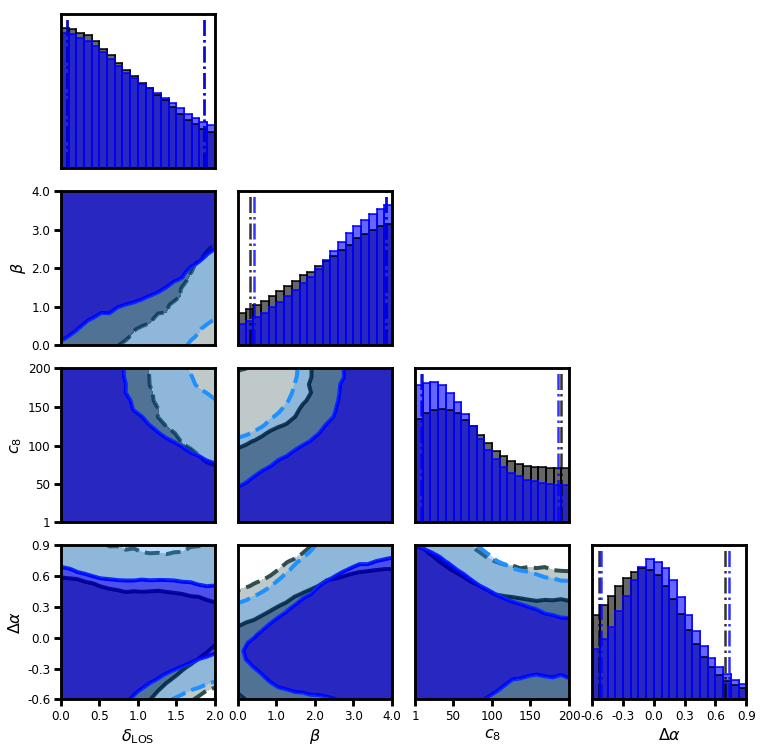

In [24]:
triangle_plot = TrianglePlot([likelihood_coupled_with_prior, likelihood_coupled_with_prior_2])
axes = triangle_plot.make_triplot(filled_contours=True, show_intervals=True, show_contours=True, 
                                  display_params=['LOS_normalization', 'beta', 'c0', 'delta_power_law_index'])

beta = r'$\beta$'
beta_ticks = [0., 1., 2., 3., 4.]
c0 = r'$c_8$'
c0_ticks = [1, 50, 100, 150, 200]
delta_power_law_index = r'$\Delta \alpha$'
dpli_ticks = [-0.6, -0.3, 0., 0.3, 0.6, 0.9]
sigma_sub = r'$\Sigma_{\rm{sub}}$'
sigma_sub_ticks = [0., 0.025, 0.05, 0.075, 0.1]
delta_LOS = r'$\delta_{\rm{LOS}}$'
dlos_ticks = [0., 0.5, 1., 1.5, 2.]
axes[4].set_ylabel(beta)
axes[4].set_yticks(beta_ticks)
axes[4].set_yticklabels(beta_ticks)

axes[8].set_ylabel(c0)
axes[8].set_yticks(c0_ticks)
axes[8].set_yticklabels(c0_ticks)

axes[12].set_ylabel(delta_power_law_index)
axes[12].set_yticks(dpli_ticks)
axes[12].set_yticklabels(dpli_ticks)

axes[12].set_xlabel(delta_LOS)
axes[12].set_xticks(dlos_ticks)
axes[12].set_xticklabels(dlos_ticks)

axes[13].set_xlabel(beta)
axes[13].set_xticks(beta_ticks)
axes[13].set_xticklabels(beta_ticks)

axes[14].set_xlabel(c0)
axes[14].set_xticks(c0_ticks)
axes[14].set_xticklabels(c0_ticks)


axes[15].set_xlabel(delta_power_law_index)
axes[15].set_xticks(dpli_ticks)
axes[15].set_xticklabels(dpli_ticks)

plt.savefig('pk_inference.pdf')

## Coupled subhalo and field halo mass functions

A reasonable assumption to impose on the inference is that the number of subhalos varies proportionally with the number of field halos, since subhalos are accreted from the field. We can enforce this by choosing an expected amplitude for the subhalo mass function in $\Lambda$CDM, and then coupling variations to $\Sigma_{\rm{sub}}$ around this value to $\delta_{\rm{LOS}}$. 

In [32]:
def couple_mass_functions(samples, sigma_sub_theory=0.05, coupling_strength=0.2):
    
    delta_los_samples = samples[:, 0]
    sigma_sub_samples = samples[:, -1]
    delta_sigma_sub = sigma_sub_samples/sigma_sub_theory
    chi2 = (delta_sigma_sub - delta_los_samples)**2/coupling_strength**2 
    return chi2

kwargs_1 = {'sigma_sub_theory': 0.05}
kwargs_2 = {'sigma_sub_theory': 0.025}
prior_on_mass_functions_1 = CustomPriorHyperCube(couple_mass_functions, param_names, param_ranges, nbins, kwargs_1)
prior_on_mass_functions_2 = CustomPriorHyperCube(couple_mass_functions, param_names, param_ranges, nbins, kwargs_2)

likelihoods_coupled_with_prior_mass_functions = likelihoods_coupled + [prior_on_mass_functions_1]
likelihood_coupled_with_prior_mass_functions_1 = IndepdendentLikelihoods(likelihoods_coupled_with_prior_mass_functions)
likelihoods_coupled_with_prior_mass_functions = likelihoods_coupled + [prior_on_mass_functions_2]
likelihood_coupled_with_prior_mass_functions_2 = IndepdendentLikelihoods(likelihoods_coupled_with_prior_mass_functions)

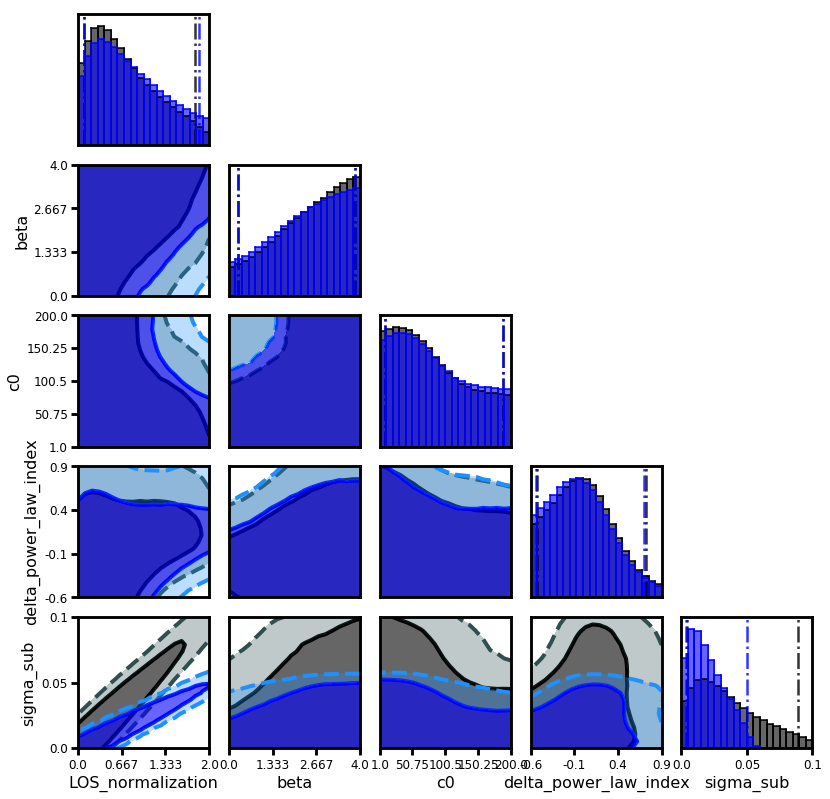

In [33]:
triangle_plot = TrianglePlot([likelihood_coupled_with_prior_mass_functions_1, likelihood_coupled_with_prior_mass_functions_2])
axes = triangle_plot.make_triplot(filled_contours=True, show_intervals=True)